In [4]:
from datetime import timedelta
import warnings
import itertools


import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
import joblib
import optuna
from datetime import datetime

warnings.filterwarnings("ignore")

## Train-test

- We will take last hour as a test, one before as val and train across other samples.
- The samples must be consistent among the blocks
- We must not shuffle data since it's time-dependent

In [5]:
df_full_ticks = pl.read_parquet("../data/processed/tx_blocks_eth_clean.parquet")

In [6]:
print(df_full_ticks.shape)
df_full_ticks.head()

(1658540, 19)


cost,gas,gas_fee_cap,gas_price,tx_time,block_hash,base_fee,gas_limit,gas_used,block_time,open_time,close_time,open,high,low,close,volume,quote_asset_volume,number_of_trades
f64,f64,f64,f64,datetime[μs],str,f64,f64,f64,datetime[μs],datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64
-0.009676,1.43768,-0.159582,-0.159582,2025-04-13 13:22:59,"""0x8dde0f4ac2de2c39f15094639fb4…",0.152506,-0.50167,-0.50167,2025-04-13 13:22:59,2025-04-13 13:22:59,2025-04-13 13:22:59.000999,-0.765297,-0.76752,-0.763006,-0.765297,0.489824,0.478077,-0.186047
-0.021672,-0.151875,0.419496,0.419496,2025-04-13 13:22:59,"""0x8dde0f4ac2de2c39f15094639fb4…",0.152506,-0.50167,-0.50167,2025-04-13 13:22:59,2025-04-13 13:22:59,2025-04-13 13:22:59.000999,-0.765297,-0.76752,-0.763006,-0.765297,0.489824,0.478077,-0.186047
5.813776,0.622033,256.684807,256.684807,2025-04-13 13:22:59,"""0x8dde0f4ac2de2c39f15094639fb4…",0.152506,-0.50167,-0.50167,2025-04-13 13:22:59,2025-04-13 13:22:59,2025-04-13 13:22:59.000999,-0.765297,-0.76752,-0.763006,-0.765297,0.489824,0.478077,-0.186047
5.813776,0.622033,256.684807,256.684807,2025-04-13 13:22:59,"""0x8dde0f4ac2de2c39f15094639fb4…",0.152506,-0.50167,-0.50167,2025-04-13 13:22:59,2025-04-13 13:22:59,2025-04-13 13:22:59.000999,-0.765297,-0.76752,-0.763006,-0.765297,0.489824,0.478077,-0.186047
0.026129,0.461073,2.197437,2.197437,2025-04-13 13:22:59,"""0x8dde0f4ac2de2c39f15094639fb4…",0.152506,-0.50167,-0.50167,2025-04-13 13:22:59,2025-04-13 13:22:59,2025-04-13 13:22:59.000999,-0.765297,-0.76752,-0.763006,-0.765297,0.489824,0.478077,-0.186047


In [7]:
max_time = df_full_ticks["tx_time"].max()
test_threshold = max_time - timedelta(hours=1)
val_threshold = test_threshold - timedelta(hours=1)

test_threshold, val_threshold

(datetime.datetime(2025, 4, 13, 12, 43, 23),
 datetime.datetime(2025, 4, 13, 11, 43, 23))

In [8]:
df_blocks = df_full_ticks.group_by("block_hash").agg(pl.col("tx_time").min().alias("block_time"))

In [9]:
df = df_full_ticks.join(df_blocks, on="block_hash", how="left")

In [10]:
train_df = df.filter(pl.col("block_time") < val_threshold)
val_df = df.filter((pl.col("block_time") >= val_threshold) & (pl.col("block_time") < test_threshold))
test_df = df.filter(pl.col("block_time") >= test_threshold)

In [11]:
train_df.shape, val_df.shape, test_df.shape

((1497811, 20), (85159, 20), (75570, 20))

In [12]:
train_df.shape

(1497811, 20)

## Methods for evaluation

In [13]:
def plot_predictions(y_true, y_pred, title="Predicted vs Actual Gas Price"):
    plt.figure(figsize=(10, 5))
    plt.plot(y_true, label="Actual")
    plt.plot(y_pred, label="Predicted")
    plt.title(title)
    plt.xlabel("Time step")
    plt.ylabel("Gas Price")
    plt.legend()
    plt.show()

def calculate_metrics(y_true, y_pred):
    epsilon = 1e-8
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
    mae = np.mean(np.abs(y_true - y_pred))
    return {"MAPE": mape, "MAE": mae}

## Models

Since our task is to measure the quality of classical algorithms for predicting time series, we assign a pseudo-time to each transaction: `block_time + i / n`, where `i` is the transaction index in the block, `n` is the number of transactions.

In [14]:
def add_pseudo_time(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy(deep=True)

    df_copy["block_time"] = pd.to_datetime(df_copy["block_time"], unit="s")
    df_copy["block_timestamp"] = df_copy["block_time"].astype("int") // 10**6

    df_copy["n_in_block"] = df_copy.groupby("block_hash")["block_hash"].transform("count")
    df_copy["tx_index_in_block"] = df_copy.groupby("block_hash").cumcount()

    df_copy["tx_timestamp"] = df_copy["block_timestamp"] + df_copy["tx_index_in_block"] / df_copy["n_in_block"]

    df_copy["tx_time"] = pd.to_datetime(df_copy["tx_timestamp"], unit="s")
    
    df_copy = df_copy.drop(columns=[
        "block_timestamp", "tx_index_in_block", "n_in_block", "tx_timestamp"
    ])

    return df_copy

In [15]:
train_df_pd = train_df.select(["gas_price", "block_time", "block_hash"]).to_pandas()

train_df_pd = add_pseudo_time(train_df_pd)
train_df_pd

,gas_price,block_time,block_hash,tx_time
0,-0.391126,2025-04-13 11:43:11,0x23300a699a06d1a2216329f153384b182ed3c8e1f546...,2025-04-13 11:43:11.000000000
1,16.307945,2025-04-13 11:43:11,0x23300a699a06d1a2216329f153384b182ed3c8e1f546...,2025-04-13 11:43:11.002890110
2,-0.204321,2025-04-13 11:43:11,0x23300a699a06d1a2216329f153384b182ed3c8e1f546...,2025-04-13 11:43:11.005780458
3,-0.389571,2025-04-13 11:43:11,0x23300a699a06d1a2216329f153384b182ed3c8e1f546...,2025-04-13 11:43:11.008670568
4,-0.374927,2025-04-13 11:43:11,0x23300a699a06d1a2216329f153384b182ed3c8e1f546...,2025-04-13 11:43:11.011560678
...,...,...,...,...
1497806,2.918082,2025-04-13 04:18:35,0x73dc6cf289cd2f4bd4260836ab091cfbc6dd962aeace...,2025-04-13 04:18:35.980620146
1497807,51.672558,2025-04-13 04:18:35,0x73dc6cf289cd2f4bd4260836ab091cfbc6dd962aeace...,2025-04-13 04:18:35.984496117
1497808,0.686325,2025-04-13 04:18:35,0x73dc6cf289cd2f4bd4260836ab091cfbc6dd962aeace...,2025-04-13 04:18:35.988372087
1497809,51.672558,2025-04-13 04:18:35,0x73dc6cf289cd2f4bd4260836ab091cfbc6dd962aeace...,2025-04-13 04:18:35.992248058


In [16]:
val_df_pd = val_df.select(["gas_price", "block_time", "block_hash"]).to_pandas()

val_df_pd = add_pseudo_time(val_df_pd)
val_df_pd

,gas_price,block_time,block_hash,tx_time
0,-0.375572,2025-04-13 12:43:11,0x8c394fa19ac8e73b238a442673807f596578f811240f...,2025-04-13 12:43:11.000000000
1,-0.307456,2025-04-13 12:43:11,0x8c394fa19ac8e73b238a442673807f596578f811240f...,2025-04-13 12:43:11.005618095
2,-0.307456,2025-04-13 12:43:11,0x8c394fa19ac8e73b238a442673807f596578f811240f...,2025-04-13 12:43:11.011235952
3,-0.172346,2025-04-13 12:43:11,0x8c394fa19ac8e73b238a442673807f596578f811240f...,2025-04-13 12:43:11.016854048
4,-0.305184,2025-04-13 12:43:11,0x8c394fa19ac8e73b238a442673807f596578f811240f...,2025-04-13 12:43:11.022471905
...,...,...,...,...
85154,-0.349337,2025-04-13 11:43:23,0xa59a33333829a72e874a5149bd10763db18c10568ccf...,2025-04-13 11:43:23.981060505
85155,0.551347,2025-04-13 11:43:23,0xa59a33333829a72e874a5149bd10763db18c10568ccf...,2025-04-13 11:43:23.984848499
85156,4.018813,2025-04-13 11:43:23,0xa59a33333829a72e874a5149bd10763db18c10568ccf...,2025-04-13 11:43:23.988636255
85157,12.421224,2025-04-13 11:43:23,0xa59a33333829a72e874a5149bd10763db18c10568ccf...,2025-04-13 11:43:23.992424250


In [17]:
test_df_pd = test_df.select(["gas_price", "block_time", "block_hash"]).to_pandas()

test_df_pd = add_pseudo_time(test_df_pd)
test_df_pd

,gas_price,block_time,block_hash,tx_time
0,-0.159582,2025-04-13 13:22:59,0x8dde0f4ac2de2c39f15094639fb4f18bc61e57fefba7...,2025-04-13 13:22:59.000000000
1,0.419496,2025-04-13 13:22:59,0x8dde0f4ac2de2c39f15094639fb4f18bc61e57fefba7...,2025-04-13 13:22:59.002146006
2,256.684807,2025-04-13 13:22:59,0x8dde0f4ac2de2c39f15094639fb4f18bc61e57fefba7...,2025-04-13 13:22:59.004291773
3,256.684807,2025-04-13 13:22:59,0x8dde0f4ac2de2c39f15094639fb4f18bc61e57fefba7...,2025-04-13 13:22:59.006437778
4,2.197437,2025-04-13 13:22:59,0x8dde0f4ac2de2c39f15094639fb4f18bc61e57fefba7...,2025-04-13 13:22:59.008583784
...,...,...,...,...
75565,2.167828,2025-04-13 12:43:23,0x8939bcb4ceac91df0861b4fbbd44e6a9d6994df4e4ee...,2025-04-13 12:43:23.992284060
75566,2.690797,2025-04-13 12:43:23,0x8939bcb4ceac91df0861b4fbbd44e6a9d6994df4e4ee...,2025-04-13 12:43:23.993827105
75567,4.519741,2025-04-13 12:43:23,0x8939bcb4ceac91df0861b4fbbd44e6a9d6994df4e4ee...,2025-04-13 12:43:23.995370388
75568,5.412400,2025-04-13 12:43:23,0x8939bcb4ceac91df0861b4fbbd44e6a9d6994df4e4ee...,2025-04-13 12:43:23.996913671


### Prophet

In [18]:
df_prophet = train_df_pd.rename(columns={"tx_time": "ds", "gas_price": "y"})

In [19]:
%%time

prophet_model = Prophet()
prophet_model.fit(df_prophet)

21:33:35 - cmdstanpy - INFO - Chain [1] start processing
21:34:36 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 17.1 s
Wall time: 1min 19s


In [20]:
prophet_forecast = prophet_model.predict(test_df_pd[["tx_time"]].rename(columns={"tx_time": "ds"}))

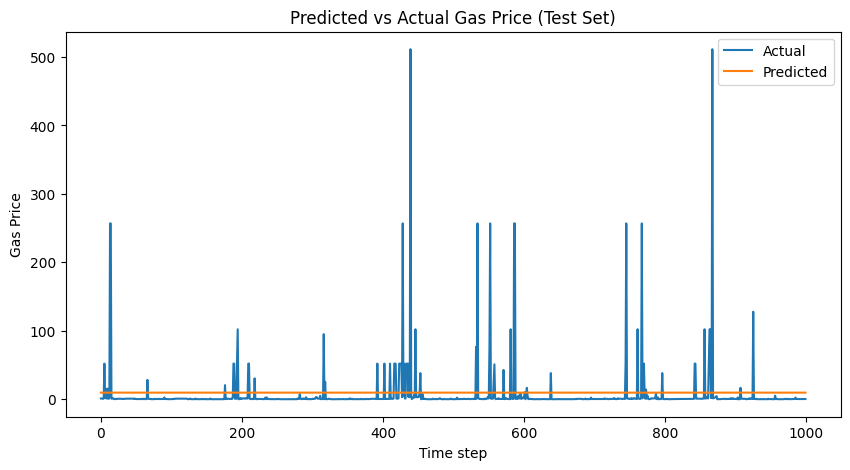

In [21]:
y_true = test_df_pd["gas_price"].to_numpy()
y_pred_prophet = prophet_forecast["yhat"].to_numpy()

plot_predictions(y_true[50:1050], y_pred_prophet[50:1050], title="Predicted vs Actual Gas Price (Test Set)")

In [22]:
prophet_metrics = calculate_metrics(y_true, y_pred_prophet)
prophet_metrics

{'MAPE': np.float64(15716.061306250755), 'MAE': np.float64(15.056559216846807)}

In [24]:
joblib.dump(prophet_model, "../models/prophet/prophet_model.pkl")

['../models/prophet/prophet_model.pkl']

Let's train the `Prophet()` model to predict the difference of neighboring gas_price values

In [25]:
train_diff_series = train_df_pd["gas_price"].diff().dropna()
df_prophet["y"] = train_diff_series

In [26]:
%%time

prophet_model = Prophet()
prophet_model.fit(df_prophet)

21:53:13 - cmdstanpy - INFO - Chain [1] start processing
21:53:34 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 16.9 s
Wall time: 38.2 s


In [27]:
prophet_forecast = prophet_model.predict(test_df_pd[["tx_time"]].rename(columns={"tx_time": "ds"}))

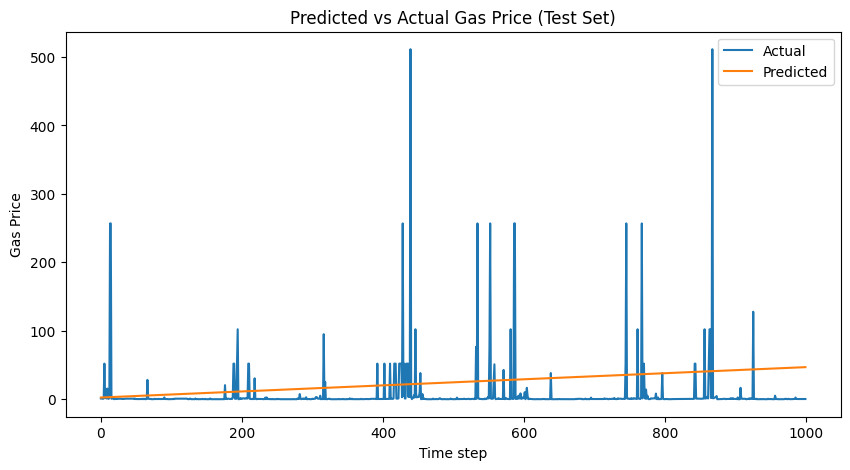

In [28]:
y_pred_prophet = prophet_forecast["yhat"].cumsum() + y_true[0]
y_pred_prophet = y_pred_prophet.to_numpy()

plot_predictions(y_true[50:1050], y_pred_prophet[50:1050], title="Predicted vs Actual Gas Price (Test Set)")

In [29]:
diff_prophet_metrics = calculate_metrics(y_true, y_pred_prophet)
diff_prophet_metrics

{'MAPE': np.float64(2936832.716951434), 'MAE': np.float64(1806.6880095893146)}

In [30]:
joblib.dump(prophet_model, "../models/prophet/diff_prophet_model.pkl")

['../models/prophet/diff_prophet_model.pkl']

### ARIMA

In [31]:
p = q = range(1, 5)
d = range(0, 3)
pdq = list(itertools.product(p, d, q))


def objective_arima(trial):
    order = trial.suggest_categorical('order', pdq)
    model = ARIMA(train_df_pd["gas_price"][train_df_pd["tx_time"] > train_df_pd["tx_time"].max() - pd.Timedelta(hours=2)], order=order)
    mdl = model.fit()
    predictions = mdl.forecast(len(val_df_pd["gas_price"]))
    predictions = pd.Series(predictions.values, index=val_df_pd.index)
    errors = val_df_pd["gas_price"] - predictions
    mae = np.mean(np.abs(errors))
    return mae

study = optuna.create_study(direction="minimize")
study.optimize(objective_arima, n_trials=10, timeout=300)

[I 2025-04-24 21:53:54,596] A new study created in memory with name: no-name-b0c83ec2-af4c-43a6-8065-28f74aede192
[I 2025-04-24 21:56:52,794] Trial 0 finished with value: 53.03301552924789 and parameters: {'order': (4, 2, 4)}. Best is trial 0 with value: 53.03301552924789.
[I 2025-04-24 21:59:10,610] Trial 1 finished with value: 14.571020144596421 and parameters: {'order': (4, 0, 3)}. Best is trial 1 with value: 14.571020144596421.


In [32]:
best_pdq = study.best_params["order"]
best_pdq

(4, 0, 3)

In [33]:
%%time

arima_model = ARIMA(train_df_pd["gas_price"], order=best_pdq)
arima_model = arima_model.fit()

CPU times: total: 8min 1s
Wall time: 8min 10s


In [34]:
arima_forecast = arima_model.forecast(steps=test_df_pd.shape[0])

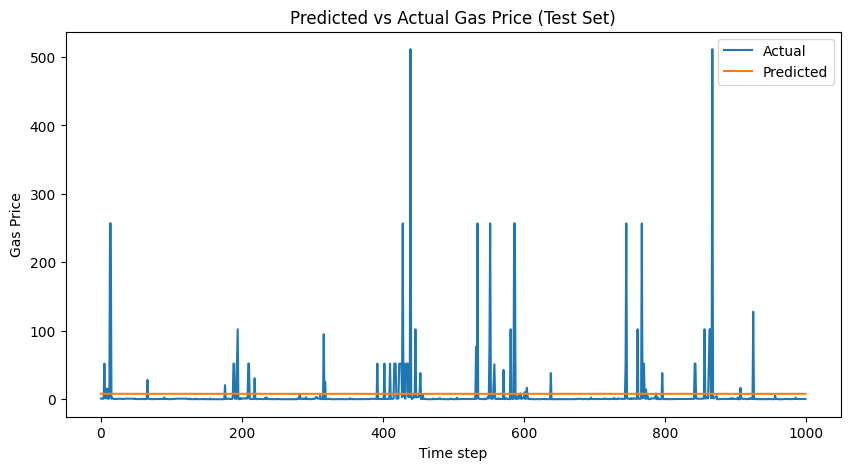

In [35]:
y_pred_arima = np.array(arima_forecast)

plot_predictions(y_true[50:1050], y_pred_arima[50:1050], title="Predicted vs Actual Gas Price (Test Set)")

In [36]:
arima_metrics = calculate_metrics(y_true, y_pred_arima)
arima_metrics

{'MAPE': np.float64(12592.456919389026), 'MAE': np.float64(13.483442721564579)}

In [37]:
joblib.dump(arima_model, "../models/arima/arima_model.pkl")

['../models/arima/arima_model.pkl']

Let's train the `ARIMA()` model to predict the difference of neighboring gas_price values

In [38]:
%%time

arima_model = ARIMA(train_df_pd["gas_price"], order=(1, 1, 0))
arima_model = arima_model.fit()

CPU times: total: 13.3 s
Wall time: 13.5 s


In [39]:
arima_forecast = arima_model.forecast(steps=test_df_pd.shape[0])

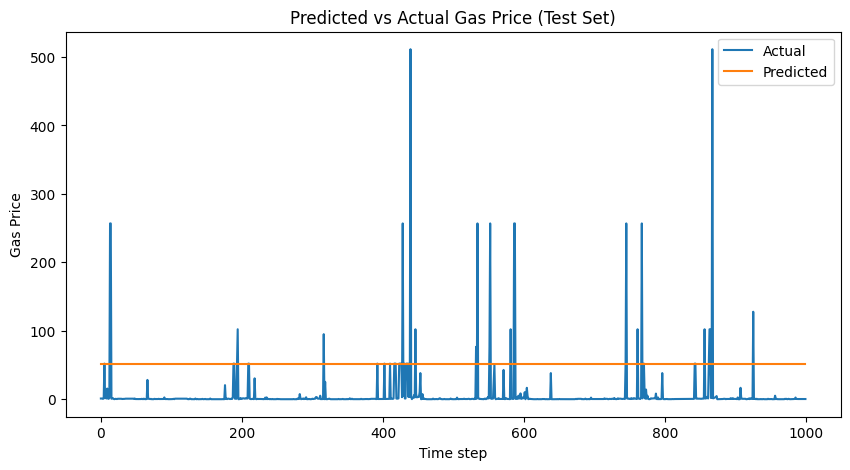

In [40]:
y_pred_arima = np.array(arima_forecast)

plot_predictions(y_true[50:1050], y_pred_arima[50:1050], title="Predicted vs Actual Gas Price (Test Set)")

In [41]:
diff_arima_metrics = calculate_metrics(y_true, y_pred_arima)
diff_arima_metrics

{'MAPE': np.float64(86417.84999528565), 'MAE': np.float64(51.51593281022966)}

In [42]:
joblib.dump(arima_model, "../models/arima/diff_arima_model.pkl")

['../models/arima/diff_arima_model.pkl']

## Conclusion

- Classical models fail to capture dependencies in the available data 💔
- Classical models perform worse at outlier detection than neural network models 😭
- Training on the difference of neighboring values of the target variable did not improve results 🥀

In [43]:
results = {
    "Prophet": prophet_metrics,
    "Diff Prophet": diff_prophet_metrics,
    "ARIMA": arima_metrics,
    "Diff ARIMA": diff_arima_metrics,
}

In [44]:
df_quality = pd.DataFrame(results).T
df_quality.index.name = "Model"

In [45]:
styled_df = df_quality.style.highlight_min(color="lightgreen", axis=0)
styled_df

,MAPE,MAE
Model,,
Prophet,15716.061306,15.056559
Diff Prophet,2936832.716951,1806.688010
ARIMA,12592.456919,13.483443
Diff ARIMA,86417.849995,51.515933
